In [4]:
!pip install --upgrade datasets

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from datasets import load_dataset
import pandas as pd
import time

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
class TransferLearningClassifier:
    def __init__(self, img_size=(224, 224), num_classes=3):
        self.img_size = img_size
        self.num_classes = num_classes
        self.models = {}
        self.histories = {}
        self.class_names = None

    def load_and_preprocess_dataset(self):
        print("Loading beans dataset from Hugging Face...")

        dataset = load_dataset("AI-Lab-Makerere/beans")
        self.class_names = dataset['train'].features['labels'].names
        print(f"Classes: {self.class_names}")

        train_images, train_labels = self._process_split(dataset['train'])
        val_images, val_labels = self._process_split(dataset['validation'])
        test_images, test_labels = self._process_split(dataset['test'])

        print(f"Training samples: {len(train_images)}")
        print(f"Validation samples: {len(val_images)}")
        print(f"Test samples: {len(test_images)}")

        return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

    def _process_split(self, split):
        images = []
        labels = []

        for item in split:
            img = item['image']
            if img.mode != 'RGB':
                img = img.convert('RGB')

            img = img.resize(self.img_size)
            img_array = np.array(img) / 255.0

            images.append(img_array)
            labels.append(item['labels'])

        return np.array(images), np.array(labels)

    def build_baseline_cnn(self):
        model = keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*self.img_size, 3)),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ], name='baseline_cnn')

        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def build_vgg16_transfer_model(self):
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(*self.img_size, 3)
        )

        base_model.trainable = False

        model = keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(self.num_classes, activation='softmax')
        ], name='vgg16_transfer')

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def build_resnet50_transfer_model(self):
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(*self.img_size, 3)
        )

        base_model.trainable = False

        model = keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(self.num_classes, activation='softmax')
        ], name='resnet50_transfer')

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def fine_tune_model(self, model, model_name):
        if 'vgg16' in model_name.lower():
            base_model = model.layers[0]
            base_model.trainable = True
            for layer in base_model.layers[:-4]:
                layer.trainable = False
        elif 'resnet50' in model_name.lower():
            base_model = model.layers[0]
            base_model.trainable = True
            for layer in base_model.layers[:-10]:
                layer.trainable = False

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.00001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def get_callbacks(self, model_name):
        callbacks = [
            EarlyStopping(
                monitor='val_accuracy',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            ModelCheckpoint(
                f'best_{model_name}_model.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-7,
                verbose=1
            )
        ]
        return callbacks

    def train_model(self, model, model_name, train_data, val_data, epochs=50, batch_size=32):
        train_images, train_labels = train_data
        val_images, val_labels = val_data

        callbacks = self.get_callbacks(model_name)

        print(f"\nTraining {model_name}...")
        start_time = time.time()

        history = model.fit(
            train_images, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(val_images, val_labels),
            callbacks=callbacks,
            verbose=1
        )

        training_time = time.time() - start_time
        print(f"{model_name} training completed in {training_time:.2f} seconds")

        self.models[model_name] = model
        self.histories[model_name] = history

        return history

    def train_with_fine_tuning(self, model, model_name, train_data, val_data,
                              initial_epochs=20, fine_tune_epochs=30, batch_size=32):

        print(f"\n=== Phase 1: Initial Training ({model_name}) ===")
        history1 = self.train_model(model, f"{model_name}_initial", train_data, val_data,
                                   epochs=initial_epochs, batch_size=batch_size)

        print(f"\n=== Phase 2: Fine-tuning ({model_name}) ===")
        model = self.fine_tune_model(model, model_name)

        history2 = model.fit(
            train_data[0], train_data[1],
            batch_size=batch_size,
            epochs=fine_tune_epochs,
            validation_data=(val_data[0], val_data[1]),
            callbacks=self.get_callbacks(f"{model_name}_finetuned"),
            verbose=1
        )

        combined_history = self._combine_histories(history1, history2)

        self.models[model_name] = model
        self.histories[model_name] = combined_history

        return combined_history

    def _combine_histories(self, hist1, hist2):
        combined = {}
        for key in hist1.history.keys():
            combined[key] = hist1.history[key] + hist2.history[key]

        class CombinedHistory:
            def __init__(self, history_dict):
                self.history = history_dict

        return CombinedHistory(combined)

    def evaluate_all_models(self, test_data):
        test_images, test_labels = test_data
        results = {}

        print("\n" + "="*80)
        print("MODEL EVALUATION RESULTS")
        print("="*80)

        for model_name, model in self.models.items():
            print(f"\nEvaluating {model_name}...")

            test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
            predictions = model.predict(test_images, verbose=0)
            predicted_classes = np.argmax(predictions, axis=1)

            report = classification_report(
                test_labels, predicted_classes,
                target_names=self.class_names,
                output_dict=True
            )

            cm = confusion_matrix(test_labels, predicted_classes)

            results[model_name] = {
                'test_loss': test_loss,
                'test_accuracy': test_accuracy,
                'predictions': predictions,
                'predicted_classes': predicted_classes,
                'classification_report': report,
                'confusion_matrix': cm
            }

            print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
            print(f"{model_name} Test Loss: {test_loss:.4f}")

        return results

    def generate_detailed_reports(self, results, test_data):
        test_images, test_labels = test_data

        print("\n" + "="*100)
        print("DETAILED CLASSIFICATION REPORTS")
        print("="*100)

        for model_name, result in results.items():
            print(f"\n{model_name.upper()} CLASSIFICATION REPORT:")
            print("-" * 60)
            print(classification_report(
                test_labels, result['predicted_classes'],
                target_names=self.class_names
            ))

        self._plot_confusion_matrices(results)
        self._plot_training_histories()
        self._create_comparison_table(results)

    def _plot_confusion_matrices(self, results):
        n_models = len(results)
        fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

        if n_models == 1:
            axes = [axes]

        for idx, (model_name, result) in enumerate(results.items()):
            cm = result['confusion_matrix']

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.class_names, yticklabels=self.class_names,
                       ax=axes[idx])
            axes[idx].set_title(f'{model_name} Confusion Matrix')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')

        plt.tight_layout()
        plt.savefig('all_confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_training_histories(self):
        n_models = len(self.histories)
        fig, axes = plt.subplots(2, n_models, figsize=(6*n_models, 10))

        if n_models == 1:
            axes = axes.reshape(-1, 1)

        for idx, (model_name, history) in enumerate(self.histories.items()):
            axes[0, idx].plot(history.history['accuracy'], label='Training Accuracy')
            axes[0, idx].plot(history.history['val_accuracy'], label='Validation Accuracy')
            axes[0, idx].set_title(f'{model_name} Accuracy')
            axes[0, idx].set_xlabel('Epoch')
            axes[0, idx].set_ylabel('Accuracy')
            axes[0, idx].legend()
            axes[0, idx].grid(True)

            axes[1, idx].plot(history.history['loss'], label='Training Loss')
            axes[1, idx].plot(history.history['val_loss'], label='Validation Loss')
            axes[1, idx].set_title(f'{model_name} Loss')
            axes[1, idx].set_xlabel('Epoch')
            axes[1, idx].set_ylabel('Loss')
            axes[1, idx].legend()
            axes[1, idx].grid(True)

        plt.tight_layout()
        plt.savefig('all_training_histories.png', dpi=300, bbox_inches='tight')
        plt.show()

    def _create_comparison_table(self, results):
        comparison_data = []

        for model_name, result in results.items():
            report = result['classification_report']

            row = {
                'Model': model_name,
                'Test Accuracy': result['test_accuracy'],
                'Test Loss': result['test_loss'],
                'Macro Avg Precision': report['macro avg']['precision'],
                'Macro Avg Recall': report['macro avg']['recall'],
                'Macro Avg F1-Score': report['macro avg']['f1-score'],
                'Weighted Avg Precision': report['weighted avg']['precision'],
                'Weighted Avg Recall': report['weighted avg']['recall'],
                'Weighted Avg F1-Score': report['weighted avg']['f1-score']
            }

            for class_name in self.class_names:
                row[f'{class_name} Precision'] = report[class_name]['precision']
                row[f'{class_name} Recall'] = report[class_name]['recall']
                row[f'{class_name} F1-Score'] = report[class_name]['f1-score']

            comparison_data.append(row)

        df = pd.DataFrame(comparison_data)

        print("\n" + "="*120)
        print("MODEL COMPARISON TABLE")
        print("="*120)
        print(df.round(4).to_string(index=False))

        df.round(4).to_csv('model_comparison.csv', index=False)
        print("\nComparison table saved as 'model_comparison.csv'")

        return df

Bean Leaf Disease Classification - Transfer Learning Comparison
Loading beans dataset from Hugging Face...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.95k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']
Training samples: 1034
Validation samples: 133
Test samples: 128

=== BUILDING AND TRAINING MODELS ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Baseline CNN model built
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16 transfer model built
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
ResNet50 transfer model built

Training baseline_cnn...
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.3244 - loss: 1.3587
Epoch 1: val_accuracy improved from -inf to 0.36090, saving model to best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 354ms/step - accuracy: 0.3247 - loss: 1.3538 - val_accuracy: 0.3609 - val_loss: 1.0859 - learning_rate: 0.0010
Epoch 2/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3948 - loss: 1.0645
Epoch 2: val_accuracy improved from 0.36090 to 0.54135, saving model to best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.3988 - loss: 1.0623 - val_accuracy: 0.5414 - val_loss: 0.9681 - learning_rate: 0.0010
Epoch 3/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4995 - loss: 1.0425
Epoch 3: val_accuracy improved from 0.54135 to 0.58647, saving model to best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.5009 - loss: 1.0392 - val_accuracy: 0.5865 - val_loss: 0.9338 - learning_rate: 0.0010
Epoch 4/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5540 - loss: 0.9238
Epoch 4: val_accuracy improved from 0.58647 to 0.63910, saving model to best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.5555 - loss: 0.9217 - val_accuracy: 0.6391 - val_loss: 0.7933 - learning_rate: 0.0010
Epoch 5/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5861 - loss: 0.9337
Epoch 5: val_accuracy did not improve from 0.63910
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5871 - loss: 0.9297 - val_accuracy: 0.6316 - val_loss: 0.7532 - learning_rate: 0.0010
Epoch 6/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5923 - loss: 0.8608
Epoch 6: val_accuracy improved from 0.63910 to 0.66917, saving model to best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.5931 - loss: 0.8587 - val_accuracy: 0.6692 - val_loss: 0.7403 - learning_rate: 0.0010
Epoch 7/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6284 - loss: 0.8496
Epoch 7: val_accuracy did not improve from 0.66917
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.6300 - loss: 0.8458 - val_accuracy: 0.6692 - val_loss: 0.6770 - learning_rate: 0.0010
Epoch 8/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6557 - loss: 0.7646
Epoch 8: val_accuracy improved from 0.66917 to 0.70677, saving model to best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.6573 - loss: 0.7618 - val_accuracy: 0.7068 - val_loss: 0.6308 - learning_rate: 0.0010
Epoch 9/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6414 - loss: 0.7720
Epoch 9: val_accuracy improved from 0.70677 to 0.73684, saving model to best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6439 - loss: 0.7679 - val_accuracy: 0.7368 - val_loss: 0.6410 - learning_rate: 0.0010
Epoch 10/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7202 - loss: 0.6618
Epoch 10: val_accuracy did not improve from 0.73684
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7205 - loss: 0.6600 - val_accuracy: 0.7143 - val_loss: 0.6040 - learning_rate: 0.0010
Epoch 11/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7198 - loss: 0.6042
Epoch 11: val_accuracy did not improve from 0.73684
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7209 - loss: 0.6021 - val_accuracy: 0.7218 - val_loss: 0.6056 - learning_rate: 0.0010
Epoch 12/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7221 - loss: 0.5938
Epoch 12: val_accuracy did not improve from 0.73684
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.7233 - loss: 0.5930 - val_accuracy: 0.7293 - val_loss: 0.6634 - learning_rate: 0.0010
Epoch 13/50
32/33 ━━━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.7848 - loss: 0.5310 - val_accuracy: 0.7519 - val_loss: 0.5910 - learning_rate: 0.0010
Epoch 16/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8043 - loss: 0.4421
Epoch 16: val_accuracy improved from 0.75188 to 0.75940, saving model to best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.8054 - loss: 0.4405 - val_accuracy: 0.7594 - val_loss: 0.5518 - learning_rate: 0.0010
Epoch 17/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8222 - loss: 0.4198
Epoch 17: val_accuracy did not improve from 0.75940
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8227 - loss: 0.4184 - val_accuracy: 0.7594 - val_loss: 0.4723 - learning_rate: 0.0010
Epoch 18/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8082 - loss: 0.4500
Epoch 18: val_accuracy improved from 0.75940 to 0.78195, saving model to best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8093 - loss: 0.4474 - val_accuracy: 0.7820 - val_loss: 0.4997 - learning_rate: 0.0010
Epoch 19/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8364 - loss: 0.4182
Epoch 19: val_accuracy did not improve from 0.78195
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.8381 - loss: 0.4153 - val_accuracy: 0.7669 - val_loss: 0.6808 - learning_rate: 0.0010
Epoch 20/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8607 - loss: 0.3598
Epoch 20: val_accuracy did not improve from 0.78195
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8618 - loss: 0.3577 - val_accuracy: 0.7669 - val_loss: 0.5581 - learning_rate: 0.0010
Epoch 21/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8543 - loss: 0.3118
Epoch 21: val_accuracy improved from 0.78195 to 0.78947, saving model to best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.8555 - loss: 0.3109 - val_accuracy: 0.7895 - val_loss: 0.7553 - learning_rate: 0.0010
Epoch 22/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8765 - loss: 0.2795
Epoch 22: val_accuracy did not improve from 0.78947

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8780 - loss: 0.2772 - val_accuracy: 0.7368 - val_loss: 0.7091 - learning_rate: 0.0010
Epoch 23/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8915 - loss: 0.2194
Epoch 23: val_accuracy improved from 0.78947 to 0.81203, saving model to best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8931 - loss: 0.2171 - val_accuracy: 0.8120 - val_loss: 0.6295 - learning_rate: 2.0000e-04
Epoch 24/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9331 - loss: 0.1562
Epoch 24: val_accuracy did not improve from 0.81203
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9339 - loss: 0.1556 - val_accuracy: 0.8045 - val_loss: 0.5822 - learning_rate: 2.0000e-04
Epoch 25/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9431 - loss: 0.1616
Epoch 25: val_accuracy improved from 0.81203 to 0.81955, saving model to best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9435 - loss: 0.1597 - val_accuracy: 0.8195 - val_loss: 0.6221 - learning_rate: 2.0000e-04
Epoch 26/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9566 - loss: 0.1256
Epoch 26: val_accuracy did not improve from 0.81955
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9568 - loss: 0.1251 - val_accuracy: 0.8120 - val_loss: 0.6061 - learning_rate: 2.0000e-04
Epoch 27/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9570 - loss: 0.1170
Epoch 27: val_accuracy did not improve from 0.81955

Epoch 27: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9573 - loss: 0.1163 - val_accuracy: 0.7895 - val_loss: 0.6120 - learning_rate: 2.0000e-04
Epoch 28/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9555 - loss: 0.1224
Epoch 28: val_accuracy did not improve from 0.81955
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9561 - loss: 0.1210 -

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9702 - loss: 0.0863 - val_accuracy: 0.8271 - val_loss: 0.6082 - learning_rate: 4.0000e-05
Epoch 30/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9754 - loss: 0.0735
Epoch 30: val_accuracy improved from 0.82707 to 0.84211, saving model to best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9755 - loss: 0.0732 - val_accuracy: 0.8421 - val_loss: 0.6226 - learning_rate: 4.0000e-05
Epoch 31/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9836 - loss: 0.0636
Epoch 31: val_accuracy did not improve from 0.84211
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9835 - loss: 0.0639 - val_accuracy: 0.8195 - val_loss: 0.6253 - learning_rate: 4.0000e-05
Epoch 32/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9803 - loss: 0.0782
Epoch 32: val_accuracy did not improve from 0.84211

Epoch 32: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9800 - loss: 0.0783 - val_accuracy: 0.8346 - val_loss: 0.6458 - learning_rate: 4.0000e-05
Epoch 33/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9693 - loss: 0.0798
Epoch 33: val_accuracy did not improve from 0.84211
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9694 - loss: 0.0791 - 

33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 518ms/step - accuracy: 0.3196 - loss: 1.1794 - val_accuracy: 0.4361 - val_loss: 1.0466 - learning_rate: 1.0000e-04
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.3641 - loss: 1.1176
Epoch 2: val_accuracy improved from 0.43609 to 0.60902, saving model to best_vgg16_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 193ms/step - accuracy: 0.3654 - loss: 1.1167 - val_accuracy: 0.6090 - val_loss: 0.9877 - learning_rate: 1.0000e-04
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4736 - loss: 1.0345
Epoch 3: val_accuracy improved from 0.60902 to 0.66165, saving model to best_vgg16_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.4742 - loss: 1.0339 - val_accuracy: 0.6617 - val_loss: 0.9323 - learning_rate: 1.0000e-04
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5038 - loss: 0.9971
Epoch 4: val_accuracy improved from 0.66165 to 0.69173, saving model to best_vgg16_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.5039 - loss: 0.9967 - val_accuracy: 0.6917 - val_loss: 0.8803 - learning_rate: 1.0000e-04
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5829 - loss: 0.9454
Epoch 5: val_accuracy improved from 0.69173 to 0.70677, saving model to best_vgg16_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.5827 - loss: 0.9447 - val_accuracy: 0.7068 - val_loss: 0.8270 - learning_rate: 1.0000e-04
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5768 - loss: 0.9231
Epoch 6: val_accuracy improved from 0.70677 to 0.72932, saving model to best_vgg16_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 0.5776 - loss: 0.9220 - val_accuracy: 0.7293 - val_loss: 0.7777 - learning_rate: 1.0000e-04
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6066 - loss: 0.8579
Epoch 7: val_accuracy improved from 0.72932 to 0.75188, saving model to best_vgg16_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.6072 - loss: 0.8570 - val_accuracy: 0.7519 - val_loss: 0.7380 - learning_rate: 1.0000e-04
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6278 - loss: 0.8314
Epoch 8: val_accuracy improved from 0.75188 to 0.76692, saving model to best_vgg16_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.6283 - loss: 0.8308 - val_accuracy: 0.7669 - val_loss: 0.7041 - learning_rate: 1.0000e-04
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6355 - loss: 0.7914
Epoch 9: val_accuracy did not improve from 0.76692
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.6361 - loss: 0.7908 - val_accuracy: 0.7594 - val_loss: 0.6765 - learning_rate: 1.0000e-04
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6822 - loss: 0.7537
Epoch 10: val_accuracy improved from 0.76692 to 0.77444, saving model to best_vgg16_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.6827 - loss: 0.7529 - val_accuracy: 0.7744 - val_loss: 0.6511 - learning_rate: 1.0000e-04
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6831 - loss: 0.7378
Epoch 11: val_accuracy did not improve from 0.77444
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.6836 - loss: 0.7373 - val_accuracy: 0.7669 - val_loss: 0.6345 - learning_rate: 1.0000e-04
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6675 - loss: 0.7201
Epoch 12: val_accuracy improved from 0.77444 to 0.78947, saving model to best_vgg16_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - accuracy: 0.6688 - loss: 0.7191 - val_accuracy: 0.7895 - val_loss: 0.6167 - learning_rate: 1.0000e-04
Epoch 13/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7086 - loss: 0.6742
Epoch 13: val_accuracy did not improve from 0.78947
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.7092 - loss: 0.6739 - val_accuracy: 0.7895 - val_loss: 0.6018 - learning_rate: 1.0000e-04
Epoch 14/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7091 - loss: 0.6741
Epoch 14: val_accuracy did not improve from 0.78947
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.7093 - loss: 0.6739 - val_accuracy: 0.7820 - val_loss: 0.5910 - learning_rate: 1.0000e-04
Epoch 15/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6960 - loss: 0.6739
Epoch 15: val_accuracy did not improve from 0.78947
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.6968 - loss: 0.6727 - val_accuracy: 0.7895 - val_loss: 0.5767 - learning_rate: 1.0000e-04
E

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.7260 - loss: 0.6201 - val_accuracy: 0.7970 - val_loss: 0.5546 - learning_rate: 1.0000e-04
Epoch 18/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7277 - loss: 0.6184
Epoch 18: val_accuracy did not improve from 0.79699
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.7288 - loss: 0.6175 - val_accuracy: 0.7895 - val_loss: 0.5446 - learning_rate: 1.0000e-04
Epoch 19/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7554 - loss: 0.5869
Epoch 19: val_accuracy improved from 0.79699 to 0.80451, saving model to best_vgg16_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.7559 - loss: 0.5863 - val_accuracy: 0.8045 - val_loss: 0.5281 - learning_rate: 1.0000e-04
Epoch 20/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7458 - loss: 0.5891
Epoch 20: val_accuracy did not improve from 0.80451
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.7460 - loss: 0.5887 - val_accuracy: 0.8045 - val_loss: 0.5234 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 19.
vgg16_transfer_initial training completed in 215.77 seconds

=== Phase 2: Fine-tuning (vgg16_transfer) ===
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7849 - loss: 0.5791
Epoch 1: val_accuracy improved from -inf to 0.79699, saving model to best_vgg16_transfer_finetuned_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 376ms/step - accuracy: 0.7855 - loss: 0.5780 - val_accuracy: 0.7970 - val_loss: 0.5153 - learning_rate: 1.0000e-05
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8031 - loss: 0.4806
Epoch 2: val_accuracy improved from 0.79699 to 0.81955, saving model to best_vgg16_transfer_finetuned_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 0.8036 - loss: 0.4800 - val_accuracy: 0.8195 - val_loss: 0.4614 - learning_rate: 1.0000e-05
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8311 - loss: 0.4294
Epoch 3: val_accuracy improved from 0.81955 to 0.83459, saving model to best_vgg16_transfer_finetuned_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.8313 - loss: 0.4288 - val_accuracy: 0.8346 - val_loss: 0.4016 - learning_rate: 1.0000e-05
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8470 - loss: 0.3951
Epoch 4: val_accuracy improved from 0.83459 to 0.85714, saving model to best_vgg16_transfer_finetuned_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - accuracy: 0.8476 - loss: 0.3941 - val_accuracy: 0.8571 - val_loss: 0.3721 - learning_rate: 1.0000e-05
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8567 - loss: 0.3570
Epoch 5: val_accuracy improved from 0.85714 to 0.87218, saving model to best_vgg16_transfer_finetuned_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - accuracy: 0.8574 - loss: 0.3561 - val_accuracy: 0.8722 - val_loss: 0.3521 - learning_rate: 1.0000e-05
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8852 - loss: 0.3105
Epoch 6: val_accuracy did not improve from 0.87218
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.8857 - loss: 0.3095 - val_accuracy: 0.8722 - val_loss: 0.3416 - learning_rate: 1.0000e-05
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9095 - loss: 0.2660
Epoch 7: val_accuracy did not improve from 0.87218
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.9098 - loss: 0.2650 - val_accuracy: 0.8722 - val_loss: 0.3377 - learning_rate: 1.0000e-05
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9091 - loss: 0.2626
Epoch 8: val_accuracy did not improve from 0.87218
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.9099 - loss: 0.2612 - val_accuracy: 0.8571 - val_loss: 0.3422 - learning_rate: 1.0000e-05
Epoch 

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.9466 - loss: 0.1778 - val_accuracy: 0.9023 - val_loss: 0.2998 - learning_rate: 1.0000e-05
Epoch 12/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9546 - loss: 0.1505
Epoch 12: val_accuracy did not improve from 0.90226
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 0.9549 - loss: 0.1497 - val_accuracy: 0.8722 - val_loss: 0.3040 - learning_rate: 1.0000e-05
Epoch 13/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9661 - loss: 0.1266
Epoch 13: val_accuracy did not improve from 0.90226
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - accuracy: 0.9663 - loss: 0.1260 - val_accuracy: 0.8496 - val_loss: 0.3426 - learning_rate: 1.0000e-05
Epoch 14/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9691 - loss: 0.1239
Epoch 14: val_accuracy did not improve from 0.90226
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.9691 - loss: 0.1234 - val_accuracy: 0.8947 - val_loss: 0.2983 - learning_rate: 1.0000e-05
E


Epoch 24: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.9968 - loss: 0.0417 - val_accuracy: 0.9098 - val_loss: 0.3165 - learning_rate: 2.0000e-06
Epoch 25/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9930 - loss: 0.0458
Epoch 25: val_accuracy did not improve from 0.90977
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - accuracy: 0.9931 - loss: 0.0455 - val_accuracy: 0.9098 - val_loss: 0.3048 - learning_rate: 4.0000e-07
Epoch 26/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9957 - loss: 0.0362
Epoch 26: val_accuracy improved from 0.90977 to 0.91729, saving model to best_vgg16_transfer_finetuned_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.9957 - loss: 0.0361 - val_accuracy: 0.9173 - val_loss: 0.3104 - learning_rate: 4.0000e-07
Epoch 27/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9997 - loss: 0.0319
Epoch 27: val_accuracy did not improve from 0.91729
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.9996 - loss: 0.0318 - val_accuracy: 0.9173 - val_loss: 0.3115 - learning_rate: 4.0000e-07
Epoch 28/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9975 - loss: 0.0347
Epoch 28: val_accuracy did not improve from 0.91729
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.9974 - loss: 0.0347 - val_accuracy: 0.9173 - val_loss: 0.3106 - learning_rate: 4.0000e-07
Epoch 29/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9950 - loss: 0.0361
Epoch 29: val_accuracy did not improve from 0.91729

Epoch 29: ReduceLROnPlateau reducing learning rate to 1e-07.
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - accuracy: 0.9951 - loss: 0.0360 - val_acc

33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 483ms/step - accuracy: 0.4071 - loss: 1.1955 - val_accuracy: 0.3684 - val_loss: 1.0860 - learning_rate: 1.0000e-04
Epoch 2/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4731 - loss: 1.0435
Epoch 2: val_accuracy improved from 0.36842 to 0.39098, saving model to best_resnet50_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.4742 - loss: 1.0427 - val_accuracy: 0.3910 - val_loss: 1.0755 - learning_rate: 1.0000e-04
Epoch 3/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5370 - loss: 0.9940
Epoch 3: val_accuracy did not improve from 0.39098
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.5368 - loss: 0.9941 - val_accuracy: 0.3383 - val_loss: 1.0716 - learning_rate: 1.0000e-04
Epoch 4/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5496 - loss: 0.9552
Epoch 4: val_accuracy did not improve from 0.39098
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.5514 - loss: 0.9533 - val_accuracy: 0.3910 - val_loss: 1.0649 - learning_rate: 1.0000e-04
Epoch 5/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5796 - loss: 0.9232
Epoch 5: val_accuracy improved from 0.39098 to 0.42105, saving model to best_resnet50_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5803 - loss: 0.9230 - val_accuracy: 0.4211 - val_loss: 1.0546 - learning_rate: 1.0000e-04
Epoch 6/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6103 - loss: 0.8734
Epoch 6: val_accuracy did not improve from 0.42105
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.6107 - loss: 0.8725 - val_accuracy: 0.3759 - val_loss: 1.0621 - learning_rate: 1.0000e-04
Epoch 7/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5962 - loss: 0.8855
Epoch 7: val_accuracy improved from 0.42105 to 0.48120, saving model to best_resnet50_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5977 - loss: 0.8838 - val_accuracy: 0.4812 - val_loss: 1.0461 - learning_rate: 1.0000e-04
Epoch 8/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6117 - loss: 0.8331
Epoch 8: val_accuracy did not improve from 0.48120
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.6127 - loss: 0.8330 - val_accuracy: 0.4511 - val_loss: 1.0224 - learning_rate: 1.0000e-04
Epoch 9/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6348 - loss: 0.8284
Epoch 9: val_accuracy did not improve from 0.48120
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.6356 - loss: 0.8266 - val_accuracy: 0.4737 - val_loss: 1.0058 - learning_rate: 1.0000e-04
Epoch 10/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6144 - loss: 0.8343
Epoch 10: val_accuracy improved from 0.48120 to 0.59398, saving model to best_resnet50_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.6165 - loss: 0.8320 - val_accuracy: 0.5940 - val_loss: 0.9760 - learning_rate: 1.0000e-04
Epoch 11/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6303 - loss: 0.8138
Epoch 11: val_accuracy improved from 0.59398 to 0.62406, saving model to best_resnet50_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6310 - loss: 0.8122 - val_accuracy: 0.6241 - val_loss: 0.9685 - learning_rate: 1.0000e-04
Epoch 12/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6273 - loss: 0.8300
Epoch 12: val_accuracy improved from 0.62406 to 0.63158, saving model to best_resnet50_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.6288 - loss: 0.8272 - val_accuracy: 0.6316 - val_loss: 0.9366 - learning_rate: 1.0000e-04
Epoch 13/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6399 - loss: 0.7724
Epoch 13: val_accuracy did not improve from 0.63158
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.6405 - loss: 0.7718 - val_accuracy: 0.5639 - val_loss: 0.9236 - learning_rate: 1.0000e-04
Epoch 14/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6530 - loss: 0.7559
Epoch 14: val_accuracy improved from 0.63158 to 0.64662, saving model to best_resnet50_transfer_initial_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.6539 - loss: 0.7547 - val_accuracy: 0.6466 - val_loss: 0.8854 - learning_rate: 1.0000e-04
Epoch 15/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6878 - loss: 0.7595
Epoch 15: val_accuracy did not improve from 0.64662
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.6880 - loss: 0.7576 - val_accuracy: 0.6015 - val_loss: 0.8757 - learning_rate: 1.0000e-04
Epoch 16/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6648 - loss: 0.7618
Epoch 16: val_accuracy did not improve from 0.64662
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.6657 - loss: 0.7598 - val_accuracy: 0.6241 - val_loss: 0.8458 - learning_rate: 1.0000e-04
Epoch 17/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6698 - loss: 0.7285
Epoch 17: val_accuracy did not improve from 0.64662
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.6705 - loss: 0.7277 - val_accuracy: 0.6165 - val_loss: 0.8234 - learning_rate: 1.0000e-04
Epoch 1

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7001 - loss: 0.7219 - val_accuracy: 0.6617 - val_loss: 0.7875 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 20.
resnet50_transfer_initial training completed in 131.34 seconds

=== Phase 2: Fine-tuning (resnet50_transfer) ===
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.5417 - loss: 1.0816
Epoch 1: val_accuracy improved from -inf to 0.33083, saving model to best_resnet50_transfer_finetuned_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 528ms/step - accuracy: 0.5423 - loss: 1.0798 - val_accuracy: 0.3308 - val_loss: 3.0560 - learning_rate: 1.0000e-05
Epoch 2/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6059 - loss: 0.8392
Epoch 2: val_accuracy did not improve from 0.33083
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.6068 - loss: 0.8409 - val_accuracy: 0.3308 - val_loss: 4.0419 - learning_rate: 1.0000e-05
Epoch 3/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6502 - loss: 0.8343
Epoch 3: val_accuracy did not improve from 0.33083
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6510 - loss: 0.8310 - val_accuracy: 0.3308 - val_loss: 4.5690 - learning_rate: 1.0000e-05
Epoch 4/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6573 - loss: 0.7953
Epoch 4: val_accuracy did not improve from 0.33083
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.6587 - loss: 0.7936 - val_accuracy: 0.3308 - val_loss: 5.6796 - learning_rate: 1.0000e-05
Epoch 5/30

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.7478 - loss: 0.6046 - val_accuracy: 0.3383 - val_loss: 4.2093 - learning_rate: 2.0000e-06
Epoch 10/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7472 - loss: 0.5842
Epoch 10: val_accuracy improved from 0.33835 to 0.34586, saving model to best_resnet50_transfer_finetuned_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.7480 - loss: 0.5826 - val_accuracy: 0.3459 - val_loss: 3.1577 - learning_rate: 2.0000e-06
Epoch 11/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7637 - loss: 0.5808
Epoch 11: val_accuracy improved from 0.34586 to 0.35338, saving model to best_resnet50_transfer_finetuned_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7637 - loss: 0.5800 - val_accuracy: 0.3534 - val_loss: 2.3801 - learning_rate: 2.0000e-06
Epoch 12/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7458 - loss: 0.6222
Epoch 12: val_accuracy improved from 0.35338 to 0.39098, saving model to best_resnet50_transfer_finetuned_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.7469 - loss: 0.6200 - val_accuracy: 0.3910 - val_loss: 1.6678 - learning_rate: 2.0000e-06
Epoch 13/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7298 - loss: 0.5995
Epoch 13: val_accuracy improved from 0.39098 to 0.49624, saving model to best_resnet50_transfer_finetuned_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.7315 - loss: 0.5964 - val_accuracy: 0.4962 - val_loss: 1.3261 - learning_rate: 2.0000e-06
Epoch 14/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7670 - loss: 0.5347
Epoch 14: val_accuracy improved from 0.49624 to 0.56391, saving model to best_resnet50_transfer_finetuned_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.7684 - loss: 0.5341 - val_accuracy: 0.5639 - val_loss: 1.0940 - learning_rate: 2.0000e-06
Epoch 15/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7887 - loss: 0.5288
Epoch 15: val_accuracy improved from 0.56391 to 0.60902, saving model to best_resnet50_transfer_finetuned_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.7894 - loss: 0.5269 - val_accuracy: 0.6090 - val_loss: 0.9411 - learning_rate: 2.0000e-06
Epoch 16/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7789 - loss: 0.5354
Epoch 16: val_accuracy improved from 0.60902 to 0.63910, saving model to best_resnet50_transfer_finetuned_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.7798 - loss: 0.5345 - val_accuracy: 0.6391 - val_loss: 0.8793 - learning_rate: 2.0000e-06
Epoch 17/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7740 - loss: 0.5223
Epoch 17: val_accuracy improved from 0.63910 to 0.65414, saving model to best_resnet50_transfer_finetuned_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7749 - loss: 0.5205 - val_accuracy: 0.6541 - val_loss: 0.8578 - learning_rate: 2.0000e-06
Epoch 18/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7984 - loss: 0.5358
Epoch 18: val_accuracy did not improve from 0.65414
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.7978 - loss: 0.5354 - val_accuracy: 0.6466 - val_loss: 0.8363 - learning_rate: 2.0000e-06
Epoch 19/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8075 - loss: 0.4969
Epoch 19: val_accuracy did not improve from 0.65414
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.8076 - loss: 0.4967 - val_accuracy: 0.6391 - val_loss: 0.8412 - learning_rate: 2.0000e-06
Epoch 20/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8139 - loss: 0.4648
Epoch 20: val_accuracy did not improve from 0.65414
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.8134 - loss: 0.4654 - val_accuracy: 0.6541 - val_loss: 0.8288 - learning_rate: 2.0000e-06
Epoch 

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.7790 - loss: 0.5001 - val_accuracy: 0.6767 - val_loss: 0.8090 - learning_rate: 2.0000e-06
Epoch 22/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8036 - loss: 0.4705
Epoch 22: val_accuracy did not improve from 0.67669
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.8040 - loss: 0.4699 - val_accuracy: 0.6617 - val_loss: 0.7996 - learning_rate: 2.0000e-06
Epoch 23/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8247 - loss: 0.4747
Epoch 23: val_accuracy did not improve from 0.67669
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.8254 - loss: 0.4727 - val_accuracy: 0.6541 - val_loss: 0.8052 - learning_rate: 2.0000e-06
Epoch 24/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8086 - loss: 0.4817
Epoch 24: val_accuracy did not improve from 0.67669
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8091 - loss: 0.4808 - val_accuracy: 0.6466 - val_loss: 0.8007 - learning_rate: 2.0000e-06
Epoch 

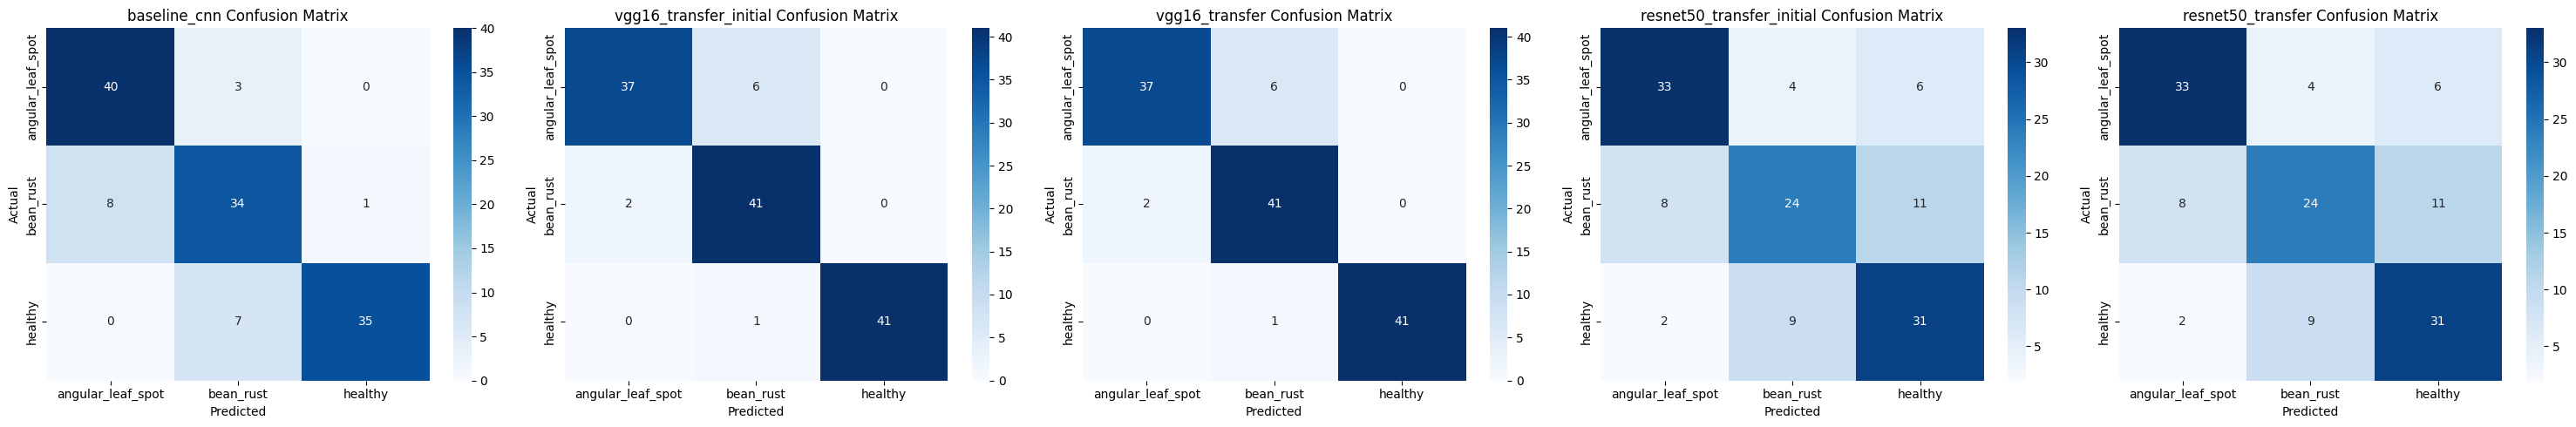

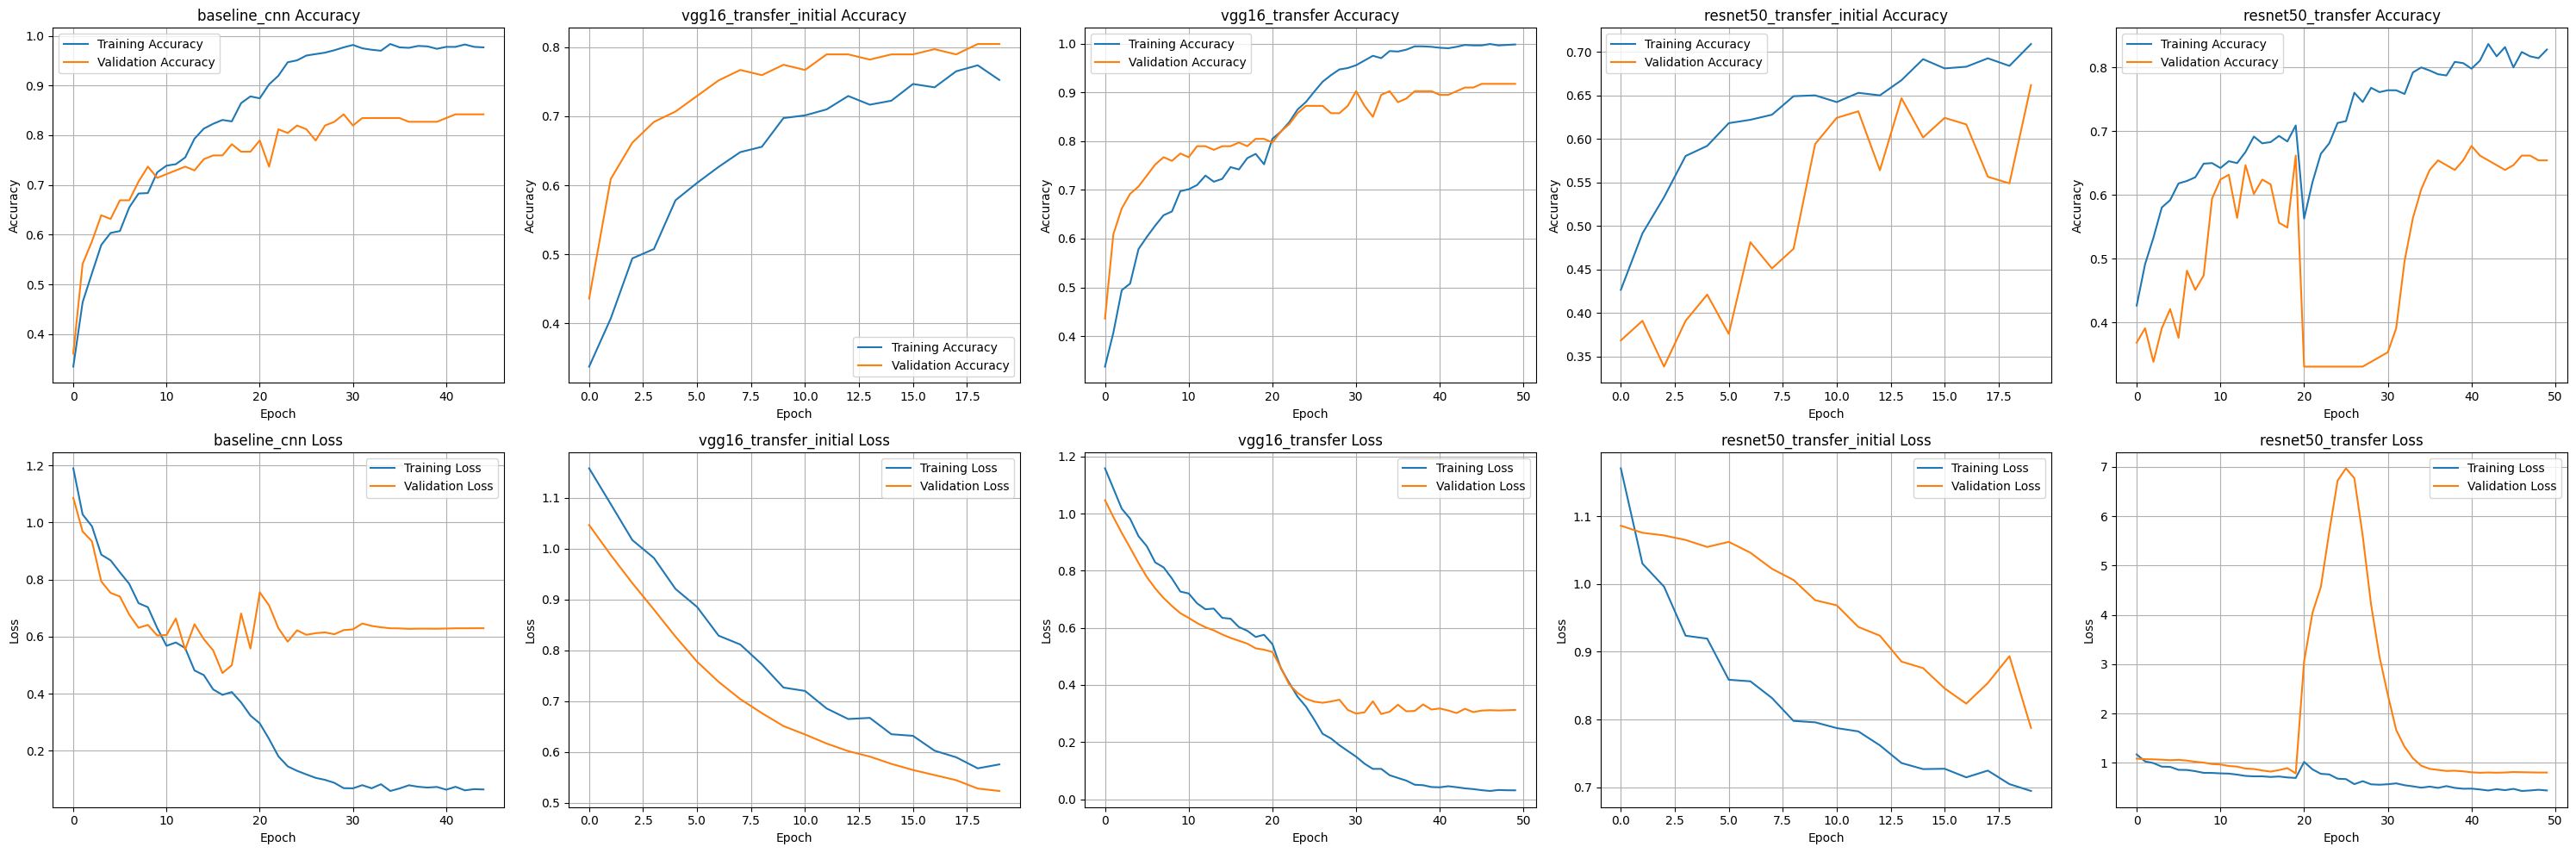


MODEL COMPARISON TABLE
                    Model  Test Accuracy  Test Loss  Macro Avg Precision  Macro Avg Recall  Macro Avg F1-Score  Weighted Avg Precision  Weighted Avg Recall  Weighted Avg F1-Score  angular_leaf_spot Precision  angular_leaf_spot Recall  angular_leaf_spot F1-Score  bean_rust Precision  bean_rust Recall  bean_rust F1-Score  healthy Precision  healthy Recall  healthy F1-Score
             baseline_cnn         0.8516     0.4557               0.8594            0.8514              0.8527                  0.8585               0.8516                 0.8524                       0.8333                    0.9302                      0.8791               0.7727            0.7907              0.7816             0.9722          0.8333            0.8974
   vgg16_transfer_initial         0.9297     0.2107               0.9343            0.9300              0.9305                  0.9338               0.9297                 0.9300                       0.9487                    0

In [ ]:
def main():
    print("Bean Leaf Disease Classification - Transfer Learning Comparison")
    print("="*70)

    classifier = TransferLearningClassifier(img_size=(224, 224), num_classes=3)

    train_data, val_data, test_data = classifier.load_and_preprocess_dataset()

    print("\n=== BUILDING AND TRAINING MODELS ===")

    baseline_model = classifier.build_baseline_cnn()
    print("Baseline CNN model built")

    vgg16_model = classifier.build_vgg16_transfer_model()
    print("VGG16 transfer model built")

    resnet50_model = classifier.build_resnet50_transfer_model()
    print("ResNet50 transfer model built")

    classifier.train_model(baseline_model, "baseline_cnn", train_data, val_data, epochs=50)

    classifier.train_with_fine_tuning(vgg16_model, "vgg16_transfer", train_data, val_data,
                                     initial_epochs=20, fine_tune_epochs=30)

    classifier.train_with_fine_tuning(resnet50_model, "resnet50_transfer", train_data, val_data,
                                     initial_epochs=20, fine_tune_epochs=30)

    results = classifier.evaluate_all_models(test_data)

    classifier.generate_detailed_reports(results, test_data)

    print("\n" + "="*80)
    print("TRAINING AND EVALUATION COMPLETED!")
    print("="*80)
    print("Files generated:")
    print("- best_baseline_cnn_model.h5")
    print("- best_vgg16_transfer_model.h5")
    print("- best_resnet50_transfer_model.h5")
    print("- all_confusion_matrices.png")
    print("- all_training_histories.png")
    print("- model_comparison.csv")

if __name__ == "__main__":
    main()

Bean Leaf Disease Classification - Transfer Learning Comparison
User: sntsemilio
Start Time: 2025-06-05 04:02:02 UTC
Models will be saved to: models_sntsemilio_20250605_040202
User: sntsemilio | Date: 2025-06-05 04:02:02 UTC
Loading beans dataset from Hugging Face...
Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']
Training samples: 1034
Validation samples: 133
Test samples: 128

=== BUILDING AND TRAINING MODELS ===
Baseline CNN model built


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


VGG16 transfer model built
ResNet50 transfer model built

Training baseline_cnn...
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.3324 - loss: 1.3709
Epoch 1: val_accuracy improved from -inf to 0.57143, saving model to models_sntsemilio_20250605_040202/best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 313ms/step - accuracy: 0.3338 - loss: 1.3652 - val_accuracy: 0.5714 - val_loss: 0.9577 - learning_rate: 0.0010
Epoch 2/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5139 - loss: 0.9854
Epoch 2: val_accuracy did not improve from 0.57143
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.5159 - loss: 0.9829 - val_accuracy: 0.5639 - val_loss: 0.8745 - learning_rate: 0.0010
Epoch 3/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5428 - loss: 0.9930
Epoch 3: val_accuracy improved from 0.57143 to 0.60150, saving model to models_sntsemilio_20250605_040202/best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.5445 - loss: 0.9887 - val_accuracy: 0.6015 - val_loss: 0.8453 - learning_rate: 0.0010
Epoch 4/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5691 - loss: 0.9094
Epoch 4: val_accuracy improved from 0.60150 to 0.60902, saving model to models_sntsemilio_20250605_040202/best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.5704 - loss: 0.9068 - val_accuracy: 0.6090 - val_loss: 0.8114 - learning_rate: 0.0010
Epoch 5/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5783 - loss: 0.8934
Epoch 5: val_accuracy did not improve from 0.60902
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5807 - loss: 0.8902 - val_accuracy: 0.5714 - val_loss: 0.7988 - learning_rate: 0.0010
Epoch 6/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5620 - loss: 0.9356
Epoch 6: val_accuracy improved from 0.60902 to 0.62406, saving model to models_sntsemilio_20250605_040202/best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.5656 - loss: 0.9301 - val_accuracy: 0.6241 - val_loss: 0.7623 - learning_rate: 0.0010
Epoch 7/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6006 - loss: 0.8583
Epoch 7: val_accuracy improved from 0.62406 to 0.69173, saving model to models_sntsemilio_20250605_040202/best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.6034 - loss: 0.8537 - val_accuracy: 0.6917 - val_loss: 0.6905 - learning_rate: 0.0010
Epoch 8/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6547 - loss: 0.7335
Epoch 8: val_accuracy improved from 0.69173 to 0.78195, saving model to models_sntsemilio_20250605_040202/best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.6564 - loss: 0.7313 - val_accuracy: 0.7820 - val_loss: 0.6244 - learning_rate: 0.0010
Epoch 9/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6850 - loss: 0.7018
Epoch 9: val_accuracy did not improve from 0.78195
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.6866 - loss: 0.6992 - val_accuracy: 0.7594 - val_loss: 0.5312 - learning_rate: 0.0010
Epoch 10/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7039 - loss: 0.6460
Epoch 10: val_accuracy did not improve from 0.78195
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.7054 - loss: 0.6433 - val_accuracy: 0.7444 - val_loss: 0.5981 - learning_rate: 0.0010
Epoch 11/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7571 - loss: 0.5546
Epoch 11: val_accuracy did not improve from 0.78195
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.7590 - loss: 0.5527 - val_accuracy: 0.7594 - val_loss: 0.5971 - learning_rate: 0.0010
Epoch 12/50
32/33 ━━━━━━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.7728 - loss: 0.5848 - val_accuracy: 0.8195 - val_loss: 0.4517 - learning_rate: 0.0010
Epoch 14/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7728 - loss: 0.5504
Epoch 14: val_accuracy did not improve from 0.81955
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7750 - loss: 0.5460 - val_accuracy: 0.7293 - val_loss: 0.5651 - learning_rate: 0.0010
Epoch 15/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8240 - loss: 0.4196
Epoch 15: val_accuracy did not improve from 0.81955
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8259 - loss: 0.4165 - val_accuracy: 0.7820 - val_loss: 0.5702 - learning_rate: 0.0010
Epoch 16/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8570 - loss: 0.3420
Epoch 16: val_accuracy did not improve from 0.81955
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8580 - loss: 0.3401 - val_accuracy: 0.8045 - val_loss: 0.5027 - learning_rate: 0.0010
Epoch 17/50
32/33 ━━━━━━━

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9505 - loss: 0.1401 - val_accuracy: 0.8496 - val_loss: 0.4022 - learning_rate: 2.0000e-04
Epoch 23/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9343 - loss: 0.1338
Epoch 23: val_accuracy did not improve from 0.84962
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9354 - loss: 0.1328 - val_accuracy: 0.8346 - val_loss: 0.4223 - learning_rate: 2.0000e-04
Epoch 24/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9518 - loss: 0.1072
Epoch 24: val_accuracy did not improve from 0.84962
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9526 - loss: 0.1063 - val_accuracy: 0.8496 - val_loss: 0.4225 - learning_rate: 2.0000e-04
Epoch 25/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9509 - loss: 0.1187
Epoch 25: val_accuracy did not improve from 0.84962
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9514 - loss: 0.1181 - val_accuracy: 0.8421 - val_loss: 0.4578 - learning_rate: 2.0000e-04
Epoch 26/5

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9728 - loss: 0.0814 - val_accuracy: 0.8571 - val_loss: 0.4349 - learning_rate: 4.0000e-05
Epoch 29/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9667 - loss: 0.0899
Epoch 29: val_accuracy improved from 0.85714 to 0.86466, saving model to models_sntsemilio_20250605_040202/best_baseline_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9668 - loss: 0.0898 - val_accuracy: 0.8647 - val_loss: 0.4326 - learning_rate: 4.0000e-05
Epoch 30/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9693 - loss: 0.0792
Epoch 30: val_accuracy did not improve from 0.86466
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9694 - loss: 0.0790 - val_accuracy: 0.8647 - val_loss: 0.4276 - learning_rate: 4.0000e-05
Epoch 31/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9718 - loss: 0.0788
Epoch 31: val_accuracy did not improve from 0.86466
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9719 - loss: 0.0785 - val_accuracy: 0.8571 - val_loss: 0.4464 - learning_rate: 4.0000e-05
Epoch 32/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9723 - loss: 0.0780
Epoch 32: val_accuracy did not improve from 0.86466

Epoch 32: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9724 - loss: 0.0776 - 

baseline_cnn training completed in 142.16 seconds
Final model saved: models_sntsemilio_20250605_040202/final_baseline_cnn_model.h5

=== Phase 1: Initial Training (vgg16_transfer) ===
Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.3725 - loss: 1.1731
Epoch 1: val_accuracy improved from -inf to 0.58647, saving model to models_sntsemilio_20250605_040202/best_vgg16_transfer_model_initial.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 308ms/step - accuracy: 0.3721 - loss: 1.1734 - val_accuracy: 0.5865 - val_loss: 1.0450 - learning_rate: 1.0000e-04
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3881 - loss: 1.1477
Epoch 2: val_accuracy improved from 0.58647 to 0.70677, saving model to models_sntsemilio_20250605_040202/best_vgg16_transfer_model_initial.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - accuracy: 0.3888 - loss: 1.1468 - val_accuracy: 0.7068 - val_loss: 0.9881 - learning_rate: 1.0000e-04
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.4184 - loss: 1.0877
Epoch 3: val_accuracy did not improve from 0.70677
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.4191 - loss: 1.0871 - val_accuracy: 0.6767 - val_loss: 0.9368 - learning_rate: 1.0000e-04
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5148 - loss: 0.9854
Epoch 4: val_accuracy did not improve from 0.70677
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.5147 - loss: 0.9852 - val_accuracy: 0.6992 - val_loss: 0.8864 - learning_rate: 1.0000e-04
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5381 - loss: 0.9546
Epoch 5: val_accuracy did not improve from 0.70677
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.5390 - loss: 0.9541 - val_accuracy: 0.6842 - val_loss: 0.8402 - learning_rate: 1.0000e-04
Epoch 6/

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.5567 - loss: 0.9295 - val_accuracy: 0.7218 - val_loss: 0.7894 - learning_rate: 1.0000e-04
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5805 - loss: 0.8777
Epoch 7: val_accuracy improved from 0.72180 to 0.74436, saving model to models_sntsemilio_20250605_040202/best_vgg16_transfer_model_initial.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.5809 - loss: 0.8773 - val_accuracy: 0.7444 - val_loss: 0.7511 - learning_rate: 1.0000e-04
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6004 - loss: 0.8254
Epoch 8: val_accuracy did not improve from 0.74436
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - accuracy: 0.6008 - loss: 0.8248 - val_accuracy: 0.7368 - val_loss: 0.7191 - learning_rate: 1.0000e-04
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6350 - loss: 0.7914
Epoch 9: val_accuracy improved from 0.74436 to 0.75940, saving model to models_sntsemilio_20250605_040202/best_vgg16_transfer_model_initial.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.6358 - loss: 0.7905 - val_accuracy: 0.7594 - val_loss: 0.6831 - learning_rate: 1.0000e-04
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6775 - loss: 0.7385
Epoch 10: val_accuracy did not improve from 0.75940
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.6781 - loss: 0.7378 - val_accuracy: 0.7594 - val_loss: 0.6596 - learning_rate: 1.0000e-04
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6881 - loss: 0.7270
Epoch 11: val_accuracy improved from 0.75940 to 0.76692, saving model to models_sntsemilio_20250605_040202/best_vgg16_transfer_model_initial.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.6883 - loss: 0.7267 - val_accuracy: 0.7669 - val_loss: 0.6364 - learning_rate: 1.0000e-04
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6697 - loss: 0.7407
Epoch 12: val_accuracy did not improve from 0.76692
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.6709 - loss: 0.7397 - val_accuracy: 0.7444 - val_loss: 0.6297 - learning_rate: 1.0000e-04
Epoch 13/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7074 - loss: 0.6965
Epoch 13: val_accuracy did not improve from 0.76692
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.7079 - loss: 0.6959 - val_accuracy: 0.7444 - val_loss: 0.6170 - learning_rate: 1.0000e-04
Epoch 14/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6898 - loss: 0.6660
Epoch 14: val_accuracy did not improve from 0.76692
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.6908 - loss: 0.6655 - val_accuracy: 0.7594 - val_loss: 0.6015 - learning_rate: 1.0000e-04
Ep

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.7274 - loss: 0.6361 - val_accuracy: 0.7820 - val_loss: 0.5602 - learning_rate: 1.0000e-04
Epoch 18/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7507 - loss: 0.6150
Epoch 18: val_accuracy did not improve from 0.78195
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.7510 - loss: 0.6145 - val_accuracy: 0.7744 - val_loss: 0.5604 - learning_rate: 1.0000e-04
Epoch 19/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7251 - loss: 0.6215
Epoch 19: val_accuracy improved from 0.78195 to 0.78947, saving model to models_sntsemilio_20250605_040202/best_vgg16_transfer_model_initial.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.7259 - loss: 0.6207 - val_accuracy: 0.7895 - val_loss: 0.5424 - learning_rate: 1.0000e-04
Epoch 20/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7475 - loss: 0.5963
Epoch 20: val_accuracy did not improve from 0.78947
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.7481 - loss: 0.5956 - val_accuracy: 0.7895 - val_loss: 0.5329 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 19.

=== Phase 2: Fine-tuning (vgg16_transfer) ===
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7332 - loss: 0.6069
Epoch 1: val_accuracy improved from -inf to 0.78947, saving model to models_sntsemilio_20250605_040202/best_vgg16_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 318ms/step - accuracy: 0.7341 - loss: 0.6059 - val_accuracy: 0.7895 - val_loss: 0.5228 - learning_rate: 1.0000e-05
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8063 - loss: 0.4770
Epoch 2: val_accuracy improved from 0.78947 to 0.81203, saving model to models_sntsemilio_20250605_040202/best_vgg16_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step - accuracy: 0.8064 - loss: 0.4768 - val_accuracy: 0.8120 - val_loss: 0.4677 - learning_rate: 1.0000e-05
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8285 - loss: 0.4514
Epoch 3: val_accuracy improved from 0.81203 to 0.85714, saving model to models_sntsemilio_20250605_040202/best_vgg16_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.8287 - loss: 0.4505 - val_accuracy: 0.8571 - val_loss: 0.4099 - learning_rate: 1.0000e-05
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8359 - loss: 0.3940
Epoch 4: val_accuracy did not improve from 0.85714
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.8365 - loss: 0.3931 - val_accuracy: 0.8346 - val_loss: 0.3938 - learning_rate: 1.0000e-05
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8747 - loss: 0.3612
Epoch 5: val_accuracy did not improve from 0.85714
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.8751 - loss: 0.3600 - val_accuracy: 0.8421 - val_loss: 0.3852 - learning_rate: 1.0000e-05
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8679 - loss: 0.3303
Epoch 6: val_accuracy improved from 0.85714 to 0.87218, saving model to models_sntsemilio_20250605_040202/best_vgg16_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.8686 - loss: 0.3293 - val_accuracy: 0.8722 - val_loss: 0.3412 - learning_rate: 1.0000e-05
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8972 - loss: 0.2850
Epoch 7: val_accuracy did not improve from 0.87218
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.8978 - loss: 0.2840 - val_accuracy: 0.8647 - val_loss: 0.3628 - learning_rate: 1.0000e-05
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9173 - loss: 0.2567
Epoch 8: val_accuracy did not improve from 0.87218
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.9176 - loss: 0.2556 - val_accuracy: 0.8571 - val_loss: 0.3326 - learning_rate: 1.0000e-05
Epoch 9/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9293 - loss: 0.2256
Epoch 9: val_accuracy did not improve from 0.87218
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.9296 - loss: 0.2246 - val_accuracy: 0.8647 - val_loss: 0.3142 - learning_rate: 1.0000e-05
Epoch 1

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.9457 - loss: 0.1557 - val_accuracy: 0.8797 - val_loss: 0.3400 - learning_rate: 1.0000e-05
Epoch 12/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9536 - loss: 0.1490
Epoch 12: val_accuracy improved from 0.87970 to 0.89474, saving model to models_sntsemilio_20250605_040202/best_vgg16_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.9540 - loss: 0.1482 - val_accuracy: 0.8947 - val_loss: 0.3280 - learning_rate: 1.0000e-05
Epoch 13/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9563 - loss: 0.1404
Epoch 13: val_accuracy did not improve from 0.89474
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.9566 - loss: 0.1397 - val_accuracy: 0.8872 - val_loss: 0.3009 - learning_rate: 1.0000e-05
Epoch 14/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9687 - loss: 0.1106
Epoch 14: val_accuracy did not improve from 0.89474
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.9688 - loss: 0.1103 - val_accuracy: 0.8797 - val_loss: 0.3098 - learning_rate: 1.0000e-05
Epoch 15/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9756 - loss: 0.1068
Epoch 15: val_accuracy did not improve from 0.89474
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.9756 - loss: 0.1063 - val_accuracy: 0.8947 - val_loss: 0.3089 - learning_rate: 1.0000e-05

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 214ms/step - accuracy: 0.9831 - loss: 0.0720 - val_accuracy: 0.9023 - val_loss: 0.3145 - learning_rate: 1.0000e-05
Epoch 18/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9870 - loss: 0.0680
Epoch 18: val_accuracy did not improve from 0.90226
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.9870 - loss: 0.0677 - val_accuracy: 0.9023 - val_loss: 0.3050 - learning_rate: 1.0000e-05
Epoch 19/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9866 - loss: 0.0606
Epoch 19: val_accuracy did not improve from 0.90226
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.9867 - loss: 0.0604 - val_accuracy: 0.8797 - val_loss: 0.3368 - learning_rate: 1.0000e-05
Epoch 20/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9929 - loss: 0.0497
Epoch 20: val_accuracy improved from 0.90226 to 0.91729, saving model to models_sntsemilio_20250605_040202/best_vgg16_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 0.9929 - loss: 0.0495 - val_accuracy: 0.9173 - val_loss: 0.3085 - learning_rate: 1.0000e-05
Epoch 21/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9907 - loss: 0.0505
Epoch 21: val_accuracy did not improve from 0.91729

Epoch 21: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.9908 - loss: 0.0501 - val_accuracy: 0.9023 - val_loss: 0.3062 - learning_rate: 1.0000e-05
Epoch 22/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9937 - loss: 0.0371
Epoch 22: val_accuracy did not improve from 0.91729
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.9938 - loss: 0.0371 - val_accuracy: 0.9098 - val_loss: 0.3181 - learning_rate: 2.0000e-06
Epoch 23/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9869 - loss: 0.0427
Epoch 23: val_accuracy did not improve from 0.91729
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9871 - loss

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 214ms/step - accuracy: 0.9927 - loss: 0.0381 - val_accuracy: 0.9248 - val_loss: 0.3162 - learning_rate: 2.0000e-06
Epoch 25/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9972 - loss: 0.0338
Epoch 25: val_accuracy did not improve from 0.92481
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.9971 - loss: 0.0337 - val_accuracy: 0.9098 - val_loss: 0.3369 - learning_rate: 2.0000e-06
Epoch 26/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9922 - loss: 0.0430
Epoch 26: val_accuracy did not improve from 0.92481

Epoch 26: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.9923 - loss: 0.0428 - val_accuracy: 0.9173 - val_loss: 0.3266 - learning_rate: 2.0000e-06
Epoch 27/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9973 - loss: 0.0327
Epoch 27: val_accuracy did not improve from 0.92481
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9974 - loss:

Final fine-tuned model saved: models_sntsemilio_20250605_040202/final_vgg16_transfer_model.h5

=== Phase 1: Initial Training (resnet50_transfer) ===
Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.3880 - loss: 1.2372
Epoch 1: val_accuracy improved from -inf to 0.33083, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_initial.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 475ms/step - accuracy: 0.3879 - loss: 1.2367 - val_accuracy: 0.3308 - val_loss: 1.1272 - learning_rate: 1.0000e-04
Epoch 2/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4428 - loss: 1.1451
Epoch 2: val_accuracy did not improve from 0.33083
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.4440 - loss: 1.1440 - val_accuracy: 0.3308 - val_loss: 1.1085 - learning_rate: 1.0000e-04
Epoch 3/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5342 - loss: 1.0015
Epoch 3: val_accuracy improved from 0.33083 to 0.38346, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_initial.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.5340 - loss: 1.0015 - val_accuracy: 0.3835 - val_loss: 1.0854 - learning_rate: 1.0000e-04
Epoch 4/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5533 - loss: 0.9696
Epoch 4: val_accuracy did not improve from 0.38346
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.5532 - loss: 0.9687 - val_accuracy: 0.3835 - val_loss: 1.0740 - learning_rate: 1.0000e-04
Epoch 5/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5898 - loss: 0.8967
Epoch 5: val_accuracy did not improve from 0.38346
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.5897 - loss: 0.8967 - val_accuracy: 0.3759 - val_loss: 1.0711 - learning_rate: 1.0000e-04
Epoch 6/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5708 - loss: 0.9230
Epoch 6: val_accuracy improved from 0.38346 to 0.54135, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_initial.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.5728 - loss: 0.9214 - val_accuracy: 0.5414 - val_loss: 1.0439 - learning_rate: 1.0000e-04
Epoch 7/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6129 - loss: 0.8502
Epoch 7: val_accuracy did not improve from 0.54135
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.6142 - loss: 0.8498 - val_accuracy: 0.4812 - val_loss: 1.0372 - learning_rate: 1.0000e-04
Epoch 8/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6166 - loss: 0.8864
Epoch 8: val_accuracy did not improve from 0.54135
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.6165 - loss: 0.8847 - val_accuracy: 0.3759 - val_loss: 1.0512 - learning_rate: 1.0000e-04
Epoch 9/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6244 - loss: 0.8305
Epoch 9: val_accuracy did not improve from 0.54135
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.6244 - loss: 0.8307 - val_accuracy: 0.4286 - val_loss: 1.0305 - learning_rate: 1.0000e-04
Epoch 10/20
32/

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.6126 - loss: 0.8522 - val_accuracy: 0.6165 - val_loss: 0.9727 - learning_rate: 1.0000e-04
Epoch 11/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6425 - loss: 0.8060
Epoch 11: val_accuracy improved from 0.61654 to 0.64662, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_initial.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6430 - loss: 0.8049 - val_accuracy: 0.6466 - val_loss: 0.9458 - learning_rate: 1.0000e-04
Epoch 12/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6670 - loss: 0.7968
Epoch 12: val_accuracy improved from 0.64662 to 0.65414, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_initial.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.6675 - loss: 0.7946 - val_accuracy: 0.6541 - val_loss: 0.9107 - learning_rate: 1.0000e-04
Epoch 13/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6658 - loss: 0.7563
Epoch 13: val_accuracy did not improve from 0.65414
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.6667 - loss: 0.7557 - val_accuracy: 0.5414 - val_loss: 0.9355 - learning_rate: 1.0000e-04
Epoch 14/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6396 - loss: 0.8010
Epoch 14: val_accuracy did not improve from 0.65414
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.6416 - loss: 0.7984 - val_accuracy: 0.5263 - val_loss: 0.9100 - learning_rate: 1.0000e-04
Epoch 15/20
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6836 - loss: 0.7620
Epoch 15: val_accuracy did not improve from 0.65414
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.6834 - loss: 0.7612 - val_accuracy: 0.5789 - val_loss: 0.8892 - learning_rate: 1.0000e-04
Epoch 16

33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 544ms/step - accuracy: 0.5183 - loss: 1.1258 - val_accuracy: 0.3308 - val_loss: 2.4122 - learning_rate: 1.0000e-05
Epoch 2/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6017 - loss: 0.9034
Epoch 2: val_accuracy did not improve from 0.33083
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.6013 - loss: 0.9038 - val_accuracy: 0.3308 - val_loss: 3.9202 - learning_rate: 1.0000e-05
Epoch 3/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6383 - loss: 0.8466
Epoch 3: val_accuracy did not improve from 0.33083
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.6390 - loss: 0.8454 - val_accuracy: 0.3308 - val_loss: 4.7970 - learning_rate: 1.0000e-05
Epoch 4/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6539 - loss: 0.8025
Epoch 4: val_accuracy did not improve from 0.33083
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.6546 - loss: 0.8019 - val_accuracy: 0.3308 - val_loss: 5.3888 - learning_rate: 1.0000e-05
Epoch 5/30

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.7197 - loss: 0.6244 - val_accuracy: 0.3383 - val_loss: 3.7146 - learning_rate: 2.0000e-06
Epoch 10/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7250 - loss: 0.6353
Epoch 10: val_accuracy did not improve from 0.33835
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.7256 - loss: 0.6350 - val_accuracy: 0.3383 - val_loss: 2.6253 - learning_rate: 2.0000e-06
Epoch 11/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7254 - loss: 0.5993
Epoch 11: val_accuracy improved from 0.33835 to 0.37594, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.7260 - loss: 0.5997 - val_accuracy: 0.3759 - val_loss: 1.9466 - learning_rate: 2.0000e-06
Epoch 12/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7411 - loss: 0.6400
Epoch 12: val_accuracy improved from 0.37594 to 0.42857, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.7409 - loss: 0.6385 - val_accuracy: 0.4286 - val_loss: 1.5931 - learning_rate: 2.0000e-06
Epoch 13/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7418 - loss: 0.6015
Epoch 13: val_accuracy improved from 0.42857 to 0.49624, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.7426 - loss: 0.5996 - val_accuracy: 0.4962 - val_loss: 1.3080 - learning_rate: 2.0000e-06
Epoch 14/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7394 - loss: 0.6257
Epoch 14: val_accuracy improved from 0.49624 to 0.57895, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.7407 - loss: 0.6238 - val_accuracy: 0.5789 - val_loss: 1.0958 - learning_rate: 2.0000e-06
Epoch 15/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7190 - loss: 0.6117
Epoch 15: val_accuracy improved from 0.57895 to 0.59398, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.7200 - loss: 0.6107 - val_accuracy: 0.5940 - val_loss: 0.9770 - learning_rate: 2.0000e-06
Epoch 16/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7661 - loss: 0.5629
Epoch 16: val_accuracy improved from 0.59398 to 0.61654, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.7671 - loss: 0.5621 - val_accuracy: 0.6165 - val_loss: 0.9052 - learning_rate: 2.0000e-06
Epoch 17/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7347 - loss: 0.6233
Epoch 17: val_accuracy improved from 0.61654 to 0.64662, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.7365 - loss: 0.6213 - val_accuracy: 0.6466 - val_loss: 0.8434 - learning_rate: 2.0000e-06
Epoch 18/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7439 - loss: 0.5739
Epoch 18: val_accuracy improved from 0.64662 to 0.65414, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.7455 - loss: 0.5716 - val_accuracy: 0.6541 - val_loss: 0.8158 - learning_rate: 2.0000e-06
Epoch 19/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7517 - loss: 0.5420
Epoch 19: val_accuracy improved from 0.65414 to 0.69173, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.7531 - loss: 0.5411 - val_accuracy: 0.6917 - val_loss: 0.7988 - learning_rate: 2.0000e-06
Epoch 20/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7784 - loss: 0.5483
Epoch 20: val_accuracy did not improve from 0.69173
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.7786 - loss: 0.5481 - val_accuracy: 0.6692 - val_loss: 0.7934 - learning_rate: 2.0000e-06
Epoch 21/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7477 - loss: 0.5694
Epoch 21: val_accuracy did not improve from 0.69173
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7488 - loss: 0.5674 - val_accuracy: 0.6617 - val_loss: 0.7829 - learning_rate: 2.0000e-06
Epoch 22/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7712 - loss: 0.5231
Epoch 22: val_accuracy improved from 0.69173 to 0.69925, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.7714 - loss: 0.5232 - val_accuracy: 0.6992 - val_loss: 0.7830 - learning_rate: 2.0000e-06
Epoch 23/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7964 - loss: 0.5199
Epoch 23: val_accuracy improved from 0.69925 to 0.70677, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.7960 - loss: 0.5196 - val_accuracy: 0.7068 - val_loss: 0.7815 - learning_rate: 2.0000e-06
Epoch 24/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7593 - loss: 0.5423
Epoch 24: val_accuracy did not improve from 0.70677
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.7596 - loss: 0.5421 - val_accuracy: 0.6917 - val_loss: 0.7678 - learning_rate: 2.0000e-06
Epoch 25/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8180 - loss: 0.4796
Epoch 25: val_accuracy did not improve from 0.70677
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.8173 - loss: 0.4799 - val_accuracy: 0.6992 - val_loss: 0.7674 - learning_rate: 2.0000e-06
Epoch 26/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7727 - loss: 0.5569
Epoch 26: val_accuracy improved from 0.70677 to 0.71429, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.7736 - loss: 0.5552 - val_accuracy: 0.7143 - val_loss: 0.7656 - learning_rate: 2.0000e-06
Epoch 27/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7901 - loss: 0.5231
Epoch 27: val_accuracy did not improve from 0.71429
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.7905 - loss: 0.5221 - val_accuracy: 0.7068 - val_loss: 0.7714 - learning_rate: 2.0000e-06
Epoch 28/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7895 - loss: 0.4839
Epoch 28: val_accuracy improved from 0.71429 to 0.72180, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.7897 - loss: 0.4837 - val_accuracy: 0.7218 - val_loss: 0.7704 - learning_rate: 2.0000e-06
Epoch 29/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7765 - loss: 0.5247
Epoch 29: val_accuracy improved from 0.72180 to 0.73684, saving model to models_sntsemilio_20250605_040202/best_resnet50_transfer_model_finetuned.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7770 - loss: 0.5231 - val_accuracy: 0.7368 - val_loss: 0.7583 - learning_rate: 2.0000e-06
Epoch 30/30
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7959 - loss: 0.4764
Epoch 30: val_accuracy did not improve from 0.73684
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.7969 - loss: 0.4753 - val_accuracy: 0.7368 - val_loss: 0.7643 - learning_rate: 2.0000e-06
Restoring model weights from the end of the best epoch: 29.


Final fine-tuned model saved: models_sntsemilio_20250605_040202/final_resnet50_transfer_model.h5

MODEL EVALUATION RESULTS

Evaluating baseline_cnn...
baseline_cnn Test Accuracy: 0.8594
baseline_cnn Test Loss: 0.6070

Evaluating vgg16_transfer...
vgg16_transfer Test Accuracy: 0.9297
vgg16_transfer Test Loss: 0.2079

Evaluating resnet50_transfer...
resnet50_transfer Test Accuracy: 0.6953
resnet50_transfer Test Loss: 0.7283

DETAILED CLASSIFICATION REPORTS

BASELINE_CNN CLASSIFICATION REPORT:
------------------------------------------------------------
                   precision    recall  f1-score   support

angular_leaf_spot       0.85      0.93      0.89        43
        bean_rust       0.78      0.81      0.80        43
          healthy       0.97      0.83      0.90        42

         accuracy                           0.86       128
        macro avg       0.87      0.86      0.86       128
     weighted avg       0.87      0.86      0.86       128


VGG16_TRANSFER CLASSIFICAT

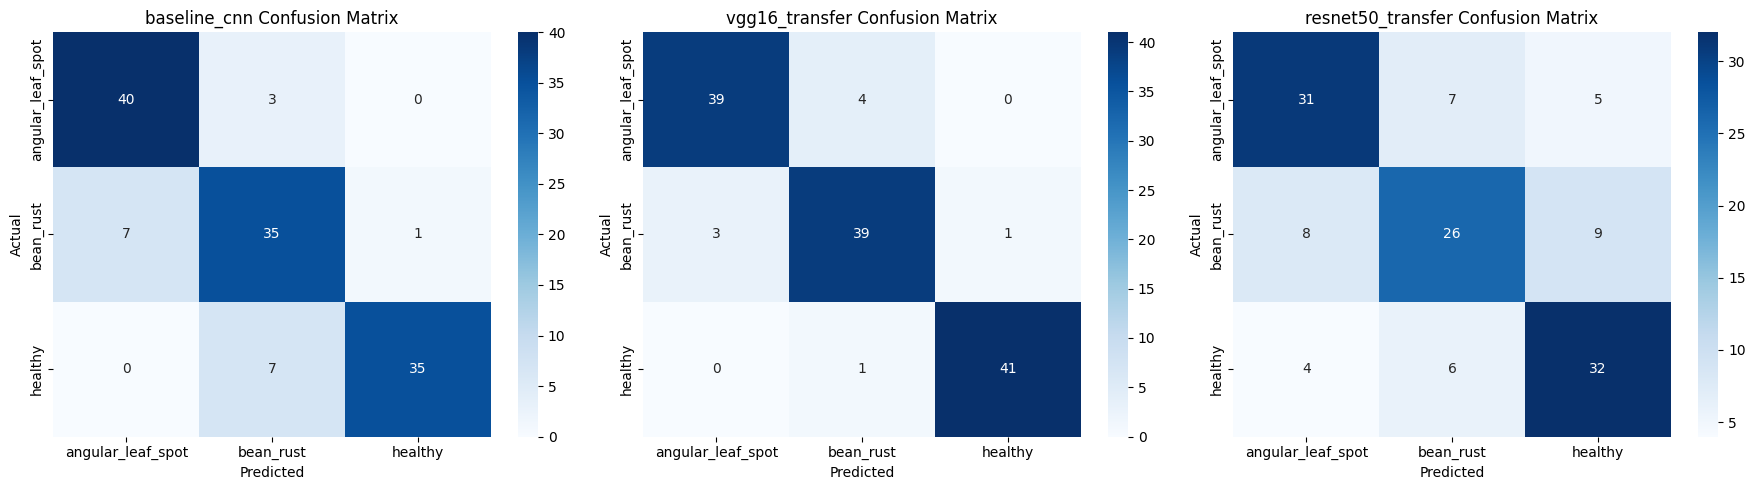

Training histories saved: models_sntsemilio_20250605_040202/all_training_histories.png


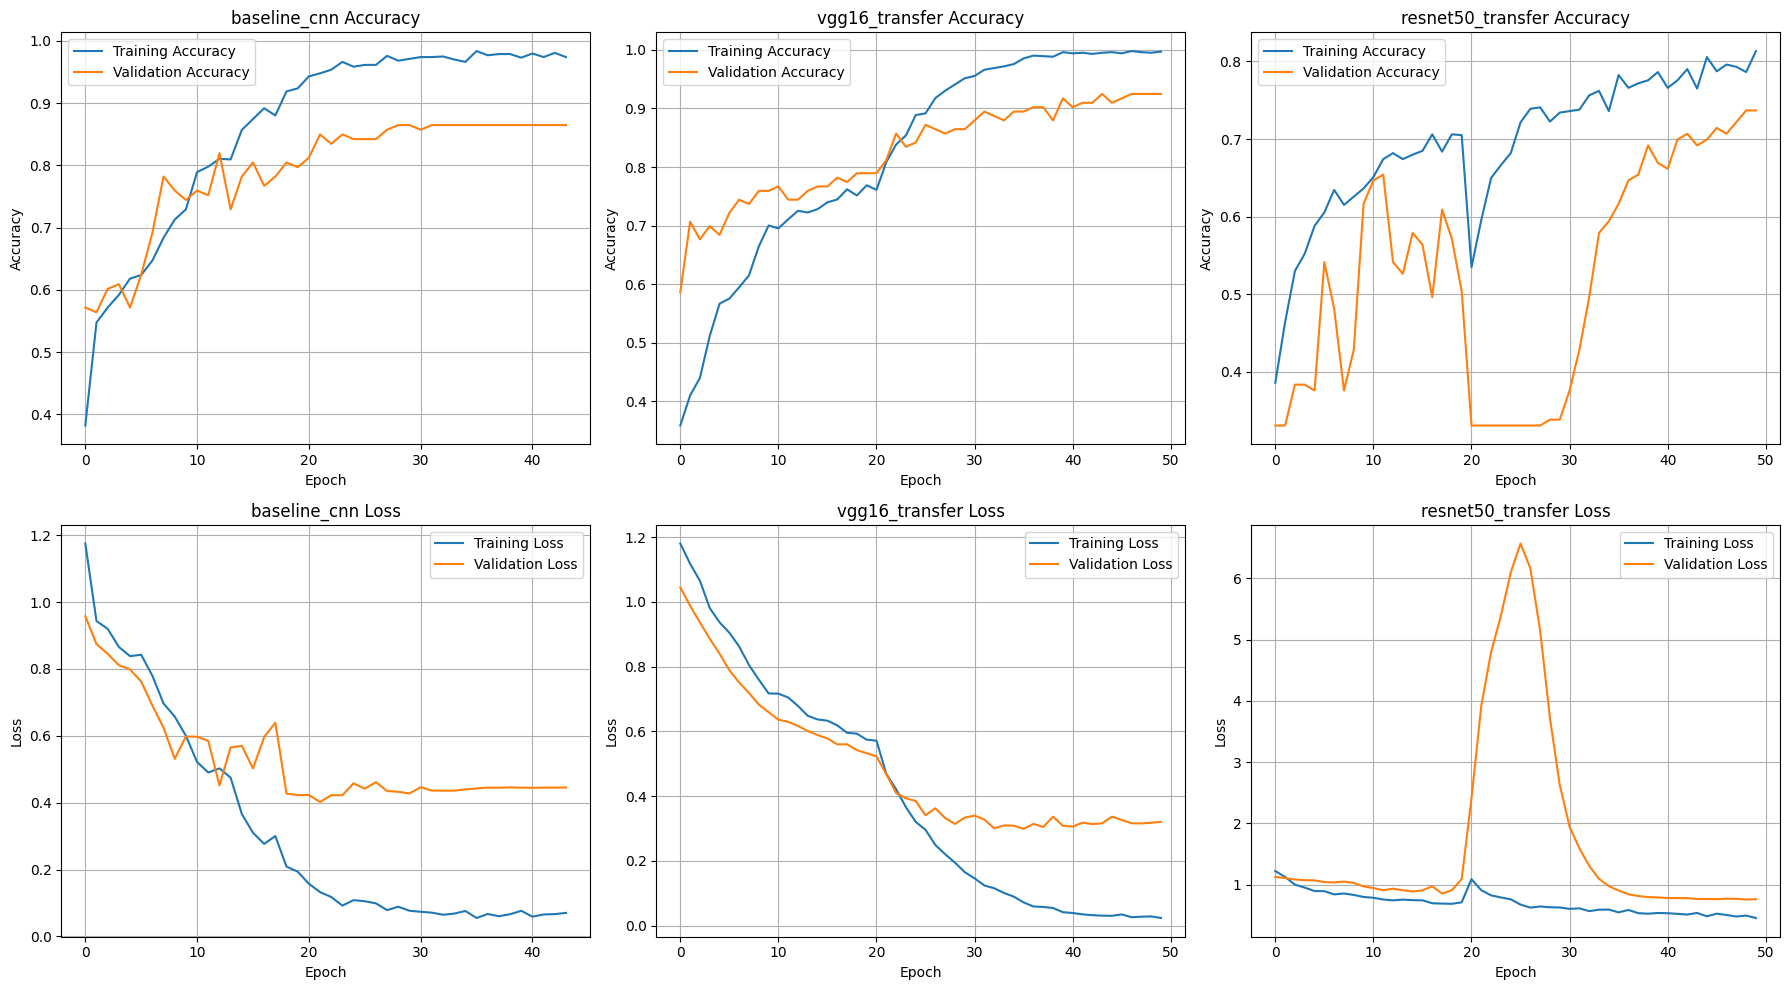


MODEL COMPARISON TABLE
            Model  Test Accuracy  Test Loss  Macro Avg Precision  Macro Avg Recall  Macro Avg F1-Score  Weighted Avg Precision  Weighted Avg Recall  Weighted Avg F1-Score  angular_leaf_spot Precision  angular_leaf_spot Recall  angular_leaf_spot F1-Score  bean_rust Precision  bean_rust Recall  bean_rust F1-Score  healthy Precision  healthy Recall  healthy F1-Score
     baseline_cnn         0.8594     0.6070               0.8670            0.8592              0.8606                  0.8662               0.8594                 0.8603                       0.8511                    0.9302                      0.8889               0.7778            0.8140              0.7955             0.9722          0.8333            0.8974
   vgg16_transfer         0.9297     0.2079               0.9304            0.9300              0.9301                  0.9300               0.9297                 0.9298                       0.9286                    0.9070                   

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from datasets import load_dataset
import pandas as pd
import time
import os
from datetime import datetime

tf.random.set_seed(42)
np.random.seed(42)

class TransferLearningClassifier:
    def __init__(self, img_size=(224, 224), num_classes=3):
        self.img_size = img_size
        self.num_classes = num_classes
        self.models = {}
        self.histories = {}
        self.class_names = None

        # Create directory for models with user and timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.save_dir = f'models_sntsemilio_{timestamp}'
        os.makedirs(self.save_dir, exist_ok=True)

        print(f"Models will be saved to: {self.save_dir}")
        print(f"User: sntsemilio | Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S UTC')}")

    def load_and_preprocess_dataset(self):
        print("Loading beans dataset from Hugging Face...")

        dataset = load_dataset("AI-Lab-Makerere/beans")
        self.class_names = dataset['train'].features['labels'].names
        print(f"Classes: {self.class_names}")

        train_images, train_labels = self._process_split(dataset['train'])
        val_images, val_labels = self._process_split(dataset['validation'])
        test_images, test_labels = self._process_split(dataset['test'])

        print(f"Training samples: {len(train_images)}")
        print(f"Validation samples: {len(val_images)}")
        print(f"Test samples: {len(test_images)}")

        return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

    def _process_split(self, split):
        images = []
        labels = []

        for item in split:
            img = item['image']
            if img.mode != 'RGB':
                img = img.convert('RGB')

            img = img.resize(self.img_size)
            img_array = np.array(img) / 255.0

            images.append(img_array)
            labels.append(item['labels'])

        return np.array(images), np.array(labels)

    def build_baseline_cnn(self):
        model = keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*self.img_size, 3)),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ], name='baseline_cnn')

        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def build_vgg16_transfer_model(self):
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(*self.img_size, 3)
        )

        base_model.trainable = False

        model = keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(self.num_classes, activation='softmax')
        ], name='vgg16_transfer')

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def build_resnet50_transfer_model(self):
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(*self.img_size, 3)
        )

        base_model.trainable = False

        model = keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(self.num_classes, activation='softmax')
        ], name='resnet50_transfer')

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def fine_tune_model(self, model, model_name):
        if 'vgg16' in model_name.lower():
            base_model = model.layers[0]
            base_model.trainable = True
            for layer in base_model.layers[:-4]:
                layer.trainable = False
        elif 'resnet50' in model_name.lower():
            base_model = model.layers[0]
            base_model.trainable = True
            for layer in base_model.layers[:-10]:
                layer.trainable = False

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.00001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def get_callbacks(self, model_name, phase=""):
        """Get callbacks including H5 model saving"""
        file_suffix = f"_{phase}" if phase else ""

        callbacks = [
            EarlyStopping(
                monitor='val_accuracy',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            # Save H5 model file
            ModelCheckpoint(
                f'{self.save_dir}/best_{model_name}_model{file_suffix}.h5',
                monitor='val_accuracy',
                save_best_only=True,
                save_weights_only=False,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-7,
                verbose=1
            )
        ]
        return callbacks

    def train_model(self, model, model_name, train_data, val_data, epochs=50, batch_size=32):
        train_images, train_labels = train_data
        val_images, val_labels = val_data

        callbacks = self.get_callbacks(model_name)

        print(f"\nTraining {model_name}...")
        start_time = time.time()

        history = model.fit(
            train_images, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(val_images, val_labels),
            callbacks=callbacks,
            verbose=1
        )

        training_time = time.time() - start_time
        print(f"{model_name} training completed in {training_time:.2f} seconds")

        # Save final model as well
        final_model_path = f'{self.save_dir}/final_{model_name}_model.h5'
        model.save(final_model_path)
        print(f"Final model saved: {final_model_path}")

        self.models[model_name] = model
        self.histories[model_name] = history

        return history

    def train_with_fine_tuning(self, model, model_name, train_data, val_data,
                              initial_epochs=20, fine_tune_epochs=30, batch_size=32):

        print(f"\n=== Phase 1: Initial Training ({model_name}) ===")

        # Phase 1: Initial training with frozen base
        callbacks_initial = self.get_callbacks(model_name, "initial")

        history1 = model.fit(
            train_data[0], train_data[1],
            batch_size=batch_size,
            epochs=initial_epochs,
            validation_data=(val_data[0], val_data[1]),
            callbacks=callbacks_initial,
            verbose=1
        )

        print(f"\n=== Phase 2: Fine-tuning ({model_name}) ===")

        # Phase 2: Fine-tuning with unfrozen layers
        model = self.fine_tune_model(model, model_name)
        callbacks_finetuned = self.get_callbacks(model_name, "finetuned")

        history2 = model.fit(
            train_data[0], train_data[1],
            batch_size=batch_size,
            epochs=fine_tune_epochs,
            validation_data=(val_data[0], val_data[1]),
            callbacks=callbacks_finetuned,
            verbose=1
        )

        # Save final fine-tuned model
        final_model_path = f'{self.save_dir}/final_{model_name}_model.h5'
        model.save(final_model_path)
        print(f"Final fine-tuned model saved: {final_model_path}")

        combined_history = self._combine_histories(history1, history2)

        self.models[model_name] = model
        self.histories[model_name] = combined_history

        return combined_history

    def _combine_histories(self, hist1, hist2):
        combined = {}
        for key in hist1.history.keys():
            combined[key] = hist1.history[key] + hist2.history[key]

        class CombinedHistory:
            def __init__(self, history_dict):
                self.history = history_dict

        return CombinedHistory(combined)

    def evaluate_all_models(self, test_data):
        test_images, test_labels = test_data
        results = {}

        print("\n" + "="*80)
        print("MODEL EVALUATION RESULTS")
        print("="*80)

        for model_name, model in self.models.items():
            print(f"\nEvaluating {model_name}...")

            test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
            predictions = model.predict(test_images, verbose=0)
            predicted_classes = np.argmax(predictions, axis=1)

            report = classification_report(
                test_labels, predicted_classes,
                target_names=self.class_names,
                output_dict=True
            )

            cm = confusion_matrix(test_labels, predicted_classes)

            results[model_name] = {
                'test_loss': test_loss,
                'test_accuracy': test_accuracy,
                'predictions': predictions,
                'predicted_classes': predicted_classes,
                'classification_report': report,
                'confusion_matrix': cm
            }

            print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
            print(f"{model_name} Test Loss: {test_loss:.4f}")

        return results

    def generate_detailed_reports(self, results, test_data):
        test_images, test_labels = test_data

        print("\n" + "="*100)
        print("DETAILED CLASSIFICATION REPORTS")
        print("="*100)

        for model_name, result in results.items():
            print(f"\n{model_name.upper()} CLASSIFICATION REPORT:")
            print("-" * 60)
            print(classification_report(
                test_labels, result['predicted_classes'],
                target_names=self.class_names
            ))

        self._plot_confusion_matrices(results)
        self._plot_training_histories()
        self._create_comparison_table(results)

    def _plot_confusion_matrices(self, results):
        n_models = len(results)
        fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

        if n_models == 1:
            axes = [axes]

        for idx, (model_name, result) in enumerate(results.items()):
            cm = result['confusion_matrix']

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.class_names, yticklabels=self.class_names,
                       ax=axes[idx])
            axes[idx].set_title(f'{model_name} Confusion Matrix')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')

        plt.tight_layout()
        confusion_path = f'{self.save_dir}/all_confusion_matrices.png'
        plt.savefig(confusion_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrices saved: {confusion_path}")
        plt.show()

    def _plot_training_histories(self):
        n_models = len(self.histories)
        fig, axes = plt.subplots(2, n_models, figsize=(6*n_models, 10))

        if n_models == 1:
            axes = axes.reshape(-1, 1)

        for idx, (model_name, history) in enumerate(self.histories.items()):
            axes[0, idx].plot(history.history['accuracy'], label='Training Accuracy')
            axes[0, idx].plot(history.history['val_accuracy'], label='Validation Accuracy')
            axes[0, idx].set_title(f'{model_name} Accuracy')
            axes[0, idx].set_xlabel('Epoch')
            axes[0, idx].set_ylabel('Accuracy')
            axes[0, idx].legend()
            axes[0, idx].grid(True)

            axes[1, idx].plot(history.history['loss'], label='Training Loss')
            axes[1, idx].plot(history.history['val_loss'], label='Validation Loss')
            axes[1, idx].set_title(f'{model_name} Loss')
            axes[1, idx].set_xlabel('Epoch')
            axes[1, idx].set_ylabel('Loss')
            axes[1, idx].legend()
            axes[1, idx].grid(True)

        plt.tight_layout()
        history_path = f'{self.save_dir}/all_training_histories.png'
        plt.savefig(history_path, dpi=300, bbox_inches='tight')
        print(f"Training histories saved: {history_path}")
        plt.show()

    def _create_comparison_table(self, results):
        comparison_data = []

        for model_name, result in results.items():
            report = result['classification_report']

            row = {
                'Model': model_name,
                'Test Accuracy': result['test_accuracy'],
                'Test Loss': result['test_loss'],
                'Macro Avg Precision': report['macro avg']['precision'],
                'Macro Avg Recall': report['macro avg']['recall'],
                'Macro Avg F1-Score': report['macro avg']['f1-score'],
                'Weighted Avg Precision': report['weighted avg']['precision'],
                'Weighted Avg Recall': report['weighted avg']['recall'],
                'Weighted Avg F1-Score': report['weighted avg']['f1-score']
            }

            for class_name in self.class_names:
                row[f'{class_name} Precision'] = report[class_name]['precision']
                row[f'{class_name} Recall'] = report[class_name]['recall']
                row[f'{class_name} F1-Score'] = report[class_name]['f1-score']

            comparison_data.append(row)

        df = pd.DataFrame(comparison_data)

        print("\n" + "="*120)
        print("MODEL COMPARISON TABLE")
        print("="*120)
        print(df.round(4).to_string(index=False))

        comparison_path = f'{self.save_dir}/model_comparison.csv'
        df.round(4).to_csv(comparison_path, index=False)
        print(f"\nComparison table saved: {comparison_path}")

        return df

    def list_saved_models(self):
        """List all saved H5 model files"""
        print(f"\nSaved H5 model files in {self.save_dir}:")
        if os.path.exists(self.save_dir):
            h5_files = [f for f in os.listdir(self.save_dir) if f.endswith('.h5')]
            for i, file in enumerate(sorted(h5_files), 1):
                file_path = os.path.join(self.save_dir, file)
                file_size = os.path.getsize(file_path) / (1024*1024)  # MB
                print(f"{i}. {file} ({file_size:.2f} MB)")
        else:
            print("No saved models directory found.")

def main():
    print("Bean Leaf Disease Classification - Transfer Learning Comparison")
    print("="*70)
    print(f"User: sntsemilio")
    print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S UTC')}")
    print("="*70)

    classifier = TransferLearningClassifier(img_size=(224, 224), num_classes=3)

    train_data, val_data, test_data = classifier.load_and_preprocess_dataset()

    print("\n=== BUILDING AND TRAINING MODELS ===")

    baseline_model = classifier.build_baseline_cnn()
    print("Baseline CNN model built")

    vgg16_model = classifier.build_vgg16_transfer_model()
    print("VGG16 transfer model built")

    resnet50_model = classifier.build_resnet50_transfer_model()
    print("ResNet50 transfer model built")

    classifier.train_model(baseline_model, "baseline_cnn", train_data, val_data, epochs=50)

    classifier.train_with_fine_tuning(vgg16_model, "vgg16_transfer", train_data, val_data,
                                     initial_epochs=20, fine_tune_epochs=30)

    classifier.train_with_fine_tuning(resnet50_model, "resnet50_transfer", train_data, val_data,
                                     initial_epochs=20, fine_tune_epochs=30)

    results = classifier.evaluate_all_models(test_data)

    classifier.generate_detailed_reports(results, test_data)

    # List all saved models
    classifier.list_saved_models()

    print("\n" + "="*80)
    print("TRAINING AND EVALUATION COMPLETED!")
    print(f"User: sntsemilio | Completion Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S UTC')}")
    print("="*80)
    print("Generated H5 model files:")
    print("- best_baseline_cnn_model.h5")
    print("- final_baseline_cnn_model.h5")
    print("- best_vgg16_transfer_model_initial.h5")
    print("- best_vgg16_transfer_model_finetuned.h5")
    print("- final_vgg16_transfer_model.h5")
    print("- best_resnet50_transfer_model_initial.h5")
    print("- best_resnet50_transfer_model_finetuned.h5")
    print("- final_resnet50_transfer_model.h5")
    print("\nOther files:")
    print("- all_confusion_matrices.png")
    print("- all_training_histories.png")
    print("- model_comparison.csv")

if __name__ == "__main__":
    main()